## Q1: I love pip 

- Take a piece of python code you wrote (for instance pick one of the exercises you've done for this class). 
- Turn it into a module
- Install it locally
- Deploy on pypi (only using the test-pypi server!)

<div class="alert alert-block alert-warning">
<span class="fa fa-flash"></span> VERY IMPORTANT
    
Both the pypi and test-pypi server are public on the web! Don't compromise your research by putting up something your competitors can use and steal your idea before you've published a paper on it!!! 

</div>

This is a piece of code I used in my master thesis project: paper submitted, but anyway there is nothing to steal as it is very basic functions that other people probably already wrote (probably in a better way!)

I made a public github repository which looks like that:

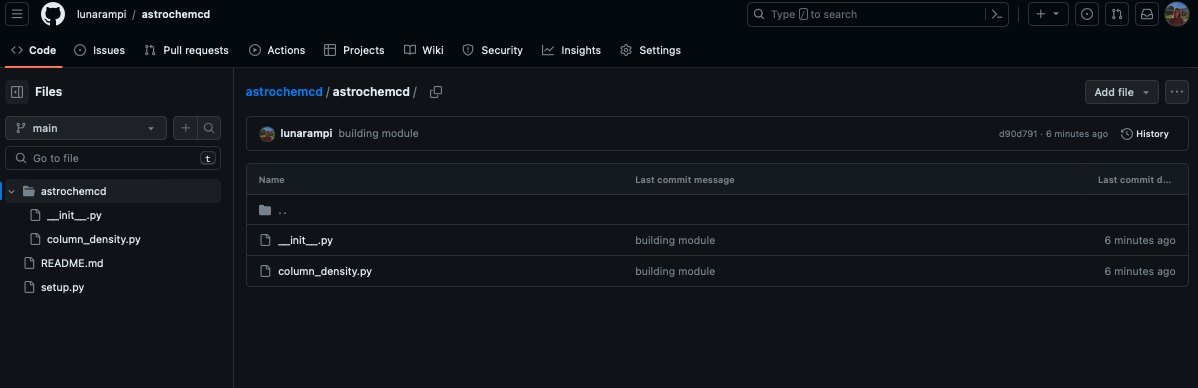

In [7]:
from IPython import display
display.Image("module_github.png")

In "README.md" I briefly explain what the module is made for.

In "setup.py" I wrote the following lines of code:

In [ ]:
from setuptools import setup, find_packages

setup(name='astrochemcd',
      description='extract molecular column density from integrated intensity maps of line emission observations',
      url='https://github.com/lunarampi',
      author='Luna Rampinelli',
      author_email='luna.rampinelli@unimi.it',
      version='0.0.1',
      packages=find_packages(),
      install_requires=['numpy', 'matplotlib', 'scipy', 'astropy', 'gofish']
     )

In column_density.py I put my piece of code (see below: just a few functions I used to call a lot in my notebooks while working on the master thesis project)

In [ ]:
#!/usr/bin/env python3

"""
Created on Mon Apr  3 11:43:48 2023

@author: lunarampinelli
"""

import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
import numpy as np
from gofish import imagecube

def N_radial_profile(path, Q, T, Tex, gu, Aul, Eu, orto_para=False, r_min=0, r_max=3, dr=0.1, inc=0.0, PA=0.0, z0=0.0, psi=1.0, r_taper=np.inf, q_taper=1.0, r_cavity=0.0):
    
    dim = int((r_max-r_min)/dr)
    rvals = np.arange(start=r_min+dr/2., stop=r_max+dr/2., step=dr)
    
    prefix, suffix = path.split('.image')
    new_string = prefix + '.JvMcorr' + '.image' + suffix
    M0 = imagecube(path)
    M0_jvm = imagecube(new_string)
    r_jvm, I_jvm, dI_jvm = M0_jvm._radial_profile_2D(rvals=rvals, assume_correlated=True, x0=0.0, y0=0.0, inc=inc, PA=PA, z0=z0, psi=psi, r_taper=r_taper, q_taper=q_taper, r_cavity=r_cavity, mask_frame='disk')
    r, I, dI = M0._radial_profile_2D(rvals=rvals, assume_correlated=True, x0=0.0, y0=0.0, inc=inc, PA=PA, z0=z0, psi=psi, r_taper=r_taper, q_taper=q_taper, r_cavity=r_cavity, mask_frame='disk')

    
    N = np.zeros(dim)
    dN = np.zeros(dim)
    if orto_para is True:
        assert gu.size==2, 'provide an array of gu for orto and para'
        assert Aul.size==2, 'provide an array of Aul for orto and para'
        assert Eu.size==2, 'provide an array of Eu for orto and para'
        N_o, N_p, dN_o, dN_p = np.zeros((4,dim))
        for i in range(dim):
            N_o[i], dN_o[i] = average_column_density(dF=0.75*dI[i], Q=Q, T=T, Tex=Tex, gu=gu[0], Aul=Aul[0], F_mean=0.75*I_jvm[i], Eu=Eu[0], Area=M0_jvm._calculate_beam_area_str()/(4.84813681e-6)**2)
            N_p[i], dN_p[i] = average_column_density(dF=0.25*dI[i], Q=Q, T=T, Tex=Tex, gu=gu[1], Aul=Aul[1], F_mean=0.25*I_jvm[i], Eu=Eu[1], Area=M0_jvm._calculate_beam_area_str()/(4.84813681e-6)**2)
            N[i] = N_o[i] + N_p[i]
            dN[i] = np.sqrt(dN_o[i]**2 + dN_p[i]**2)
    else:
        for i in range(dim):
            N[i], dN[i] =  average_column_density(dF=dI[i], Q=Q, T=T, Tex=Tex, gu=gu, Aul=Aul, F_mean=I_jvm[i], Eu=Eu, Area=M0_jvm._calculate_beam_area_str()/(4.84813681e-6)**2)

    return r, N, dN

def average_column_density(Q, T, Tex, gu, Aul, F_mean, Eu, Area, dF):
    # Q -> array
    # T [K] -> array
    # Tex [K] -> float
    # gu -> upper level degeneracy
    # Aul (log) [1/s] -> Einstein coefficient
    # F_mean [Jy m/s] -> average flux density over a region
    # Eu [K] -> upper state energy level
    # Area [as^2] -> integration area
    
    # interpolate partition function with a cubic spline
    assert Q.size==T.size, 'Q and T have different sizes: provide Q corresponding to each T'
    interpolate = scipy.interpolate.CubicSpline(T, Q)
    Q_Tex = interpolate(Tex)
    
    # convertions
    h = 6.62607015e-34                                  # J s
    c = 3*10**8                                         # m/s
    
    Aul = 10**(Aul)                  
    F_mean = F_mean*10**(-26)                           # J/(m s)
    dF = dF*10**(-26)
    Area = Area*(4.84813681e-6)**2
    # average column density
    N0 = Q_Tex*4*np.pi / gu
    N = N0 * F_mean * np.exp(Eu/Tex) / (Area*h*c*Aul*10**4) # cm^(-2)
    dN = abs(N * np.sqrt((dF/F_mean)**2))
    #print((dF/F_mean)**2)
    #print((Eu*dTex/Tex**2)**2)
    
    return N, dN

def radial_column_density(dim, Q, T, Tex, gu, Aul, Eu, flux, radius, dr, plot=False, xlim=None, ylim=None, title=None, compare=None, legend=None):
    # T = np.array([18.75, 37.50, 75.00])
    # area = array of annulus area (dim)
    # flux = array of flux for each annulus (dim+1)
    # Q = np.array([Q1, Q2, Q3])
    # xlim, ylim = 2D array with limits for axes
    # radius [arcsec] = array from annular flux density
    # dr [arcsec] = annulus width
    
    assert type(dim) == int, 'dim is the number of radial points, must be integer: check with annular flux density sampling'
    N = np.zeros(dim)

    
    for i in range(dim):
        N[i] =  average_column_density(Q=Q, T=T, Tex=Tex, gu=gu, Aul=Aul, F_mean=flux[i], Eu=Eu, Area=2*np.pi*(radius[i])*dr)
        
    if plot==True:
        fig = plt.figure(figsize=(10,5), dpi=100)
        if compare is not None:
            assert compare.size == N.size, 'provide another array of N of the same size'
            assert legend is not None, 'provide labels for the legend: array 2D of str'
            plt.plot(radius, compare, label=legend[1])
            plt.plot(radius, N, label=legend[0])
            plt.legend()
        else:
            plt.plot(radius,N)
            
        if xlim is not None:
            assert xlim.size == 2, 'provide a 2D numpy array'
            plt.xlim(xlim[0],xlim[1])
        if ylim is not None:
            assert ylim.size == 2, 'provide a 2D numpy array'
            plt.ylim(ylim[0],ylim[1])
        if title is not None:
            plt.title(title)
        fig.show()

        plt.xlabel('Radius [arcsec]')
        plt.ylabel(r'Column density [cm$^{-2}$]')
        plt.yscale('log');
    
    return N

def RMS(path, r_c=5.5, r=2.5, dim=5):
    
    # r_c [arcsec] = distance of circle to integrate flux density
    # r [arcsec] = radius of the circle to calculate integrated flux density
    # dim (int) = number of iteration
    M0 = fits.open(path)
    pix_area_as = abs(M0[0].header['CDELT1'])*abs(M0[0].header['CDELT2'])*(3600**2)
    M0.close()
    
    int_flux = np.zeros(dim)
    M0 = imagecube(path)
    assert M0.data.ndim == 2, 'Provided map is not 2D: provide an integrated intensity map!'

    
    r = r_c  #arcsec
    for i in range(dim):
        theta = np.random.rand()*2*np.pi
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        mask = M0.get_mask(r_min=0, r_max=r, mask_frame='sky', x0=x, y0=y)
        data = M0.data[mask]

        int_flux[i] = np.sum(data)/(M0._calculate_beam_area_arcsec()/pix_area_as) 
    
    rms = np.nanstd(int_flux)
    return rms

I installed it locally: python setup.py install

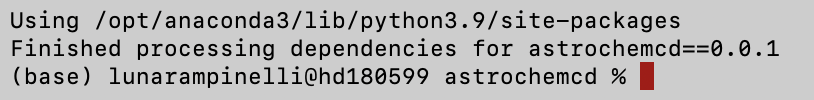

In [2]:
display.Image("install_module.png")

In [1]:
import astrochemcd

In [3]:
from astrochemcd import column_density

now deploy on pypi: https://test.pypi.org/project/astrochemcd/

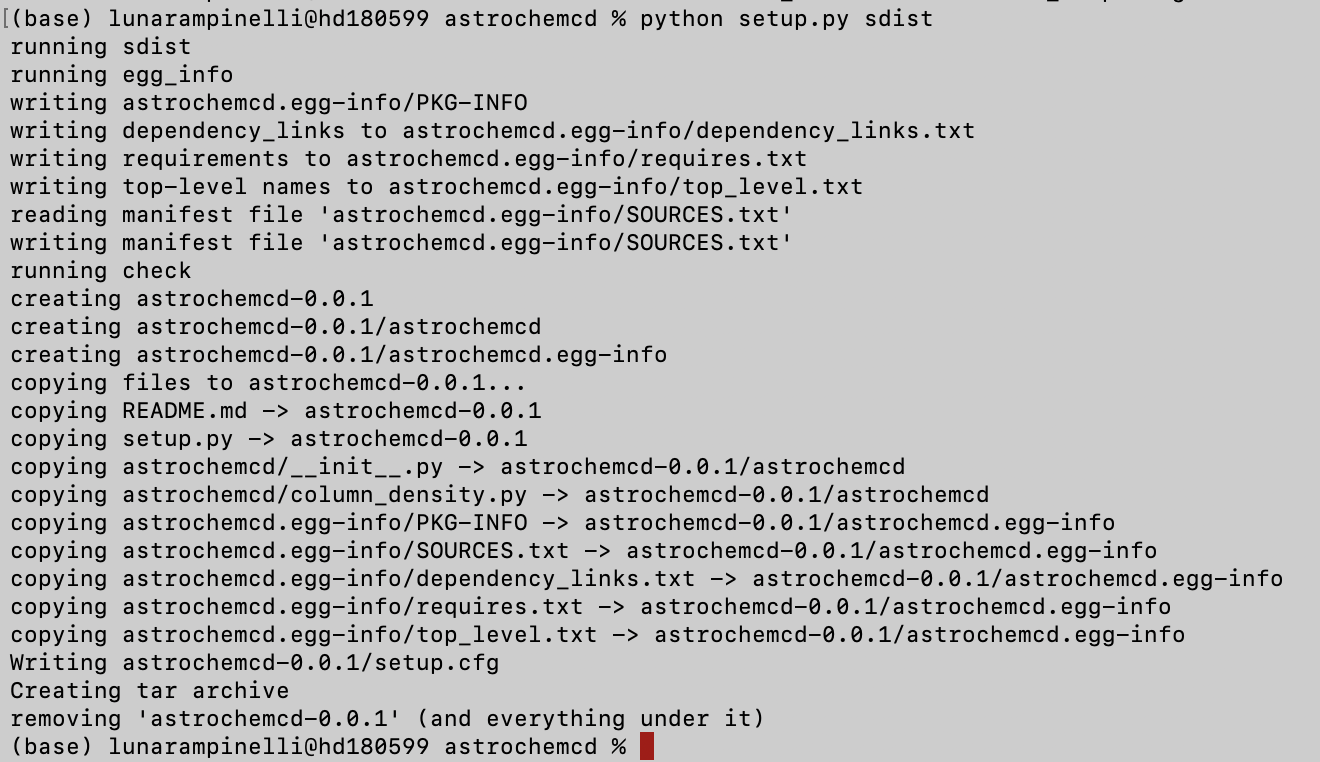

In [6]:
display.Image("sdist.png")

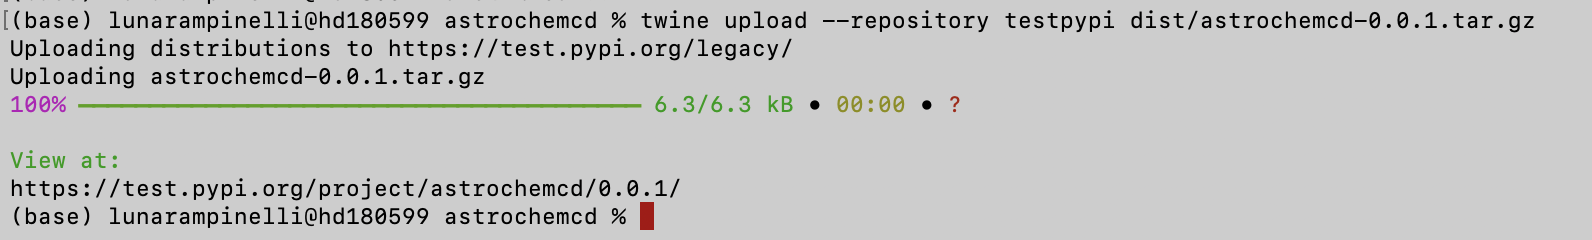

In [7]:
display.Image("install_testpypi.png")

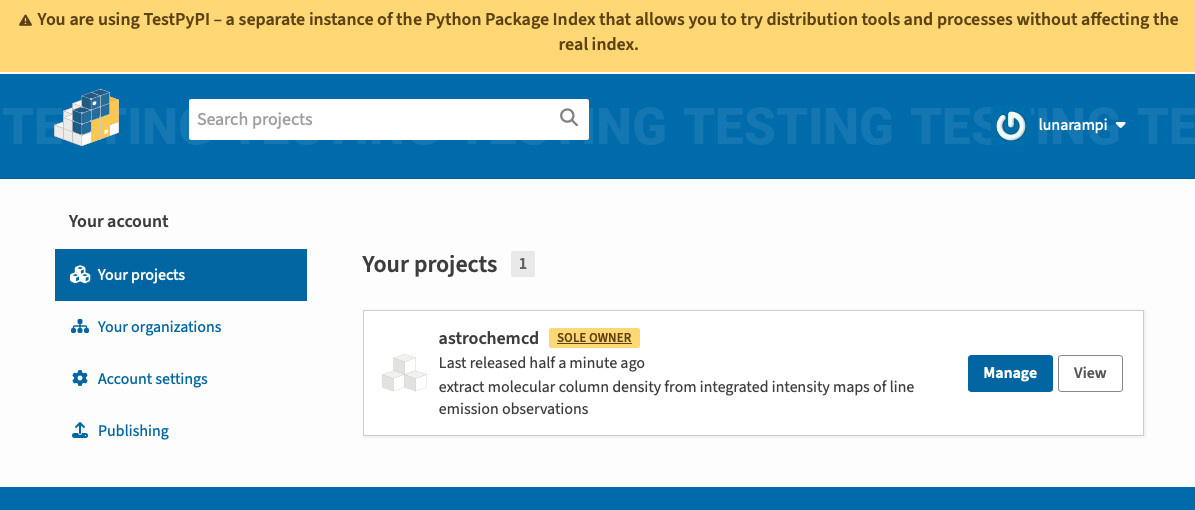

In [8]:
display.Image("001version.png")

## Q4: It's over Anakin, I have the high ground. I hate you! 

Pick a piece of your code that your really hate.  You hate it because it's soooooo slooooow. 
- Profile it.
- Find the culprit
- Rewrite that bottleneck making a better use of numpy arrays, or jitting it with Numba.
- Enjoy your faster code

**You underestimate my power**.

$\color{red}{\textbf{I will use the same code I used in exercise 3 on "scaling" about multiprocessing, lesson 7.}}$

In [9]:
# Just parameters I need in the analysis

nu_rest_HC15N_B6 = 258.15699640 # GHz
Aul_HC15N_B6 = -3.11641
gu_HC15N_B6 = 7
Q1_HC15N_B6 = 4.888774
Q2_HC15N_B6 = 9.421065
Q3_HC15N_B6 = 18.496945
Q4_HC15N_B6 = 36.660636
Q5_HC15N_B6 = 73.147586
Q6_HC15N_B6 = 111.660611
Q7_HC15N_B6 = 155.739939
Eu_HC15N_B6 = 24.77932  # K

nu_rest_HC15N_B7 = 344.20010890 # GHz
Aul_HC15N_B7 = -2.72583
gu_HC15N_B7 = 9
Q1_HC15N_B7 = 4.888774
Q2_HC15N_B7 = 9.421065
Q3_HC15N_B7 = 18.496945
Q4_HC15N_B7 = 36.660636
Q5_HC15N_B7 = 73.147586
Q6_HC15N_B7 = 111.660611
Q7_HC15N_B7 = 155.739939
Eu_HC15N_B7 = 41.29824 # K

#H13CN
nu_rest_H13CN_B6 = 259.01179760 # GHz
Aul_H13CN_B6 = -3.11210
gu_H13CN_B6 = 21
Q1_H13CN_B6 = 14.621772
Q2_H13CN_B6 = 28.170853
Q3_H13CN_B6 = 55.309534
Q4_H13CN_B6 = 109.622575
Q5_H13CN_B6 = 218.776162
Q6_H13CN_B6 = 334.118098
Q7_H13CN_B6 = 466.444525
Eu_H13CN_B6 = 24.86166 # K

nu_rest_H13CN_B7 = 345.33976930  # GHz
Aul_H13CN_B7 = -2.72155
gu_H13CN_B7 = 27
Q1_H13CN_B7 = 14.621772
Q2_H13CN_B7 = 28.170853
Q3_H13CN_B7 = 55.309534
Q4_H13CN_B7 = 109.622575
Q5_H13CN_B7 = 218.776162
Q6_H13CN_B7 = 334.118098
Q7_H13CN_B7 = 466.444525
Eu_H13CN_B7 = 41.43546 # K

In [2]:
# here I evaluate the radial profile of upper state density (Nu) for each transitions 
# starting from the radial profile of the integrated intensity ()
# the relation between flux and column density depends on a bunch line parameters (gu, Eu, Aul, Q)
# and it is defined in rot_diag_func

import numpy as np
from gofish import imagecube
import rot_diag_func as tools 

rvals = np.arange(0.2, 0.8, 0.2) 
Nu = np.zeros((2,rvals.size))
dNu = np.zeros((2,rvals.size))
names = np.array(['/Users/lunarampinelli/Documents/PHD/projects/fractionation_PDS70_B7+B6/HCN_B6+B7/PDS_70_260GHz_LB_selfcaled_H13CN_start_-4.5kms_robust2.0_0.4kms_4sigma.clean.image_M0.fits','/Users/lunarampinelli/Documents/PHD/projects/fractionation_PDS70_B7+B6/HCN_B6+B7/smoothed_to_B6_H13CN_robust2.0_0.9kms_taper0.064arcsec_3.0sigma.clean.image_M0.fits'])
names_lines = np.array(['H13CN_B6', 'H13CN_B7'])

for a in range(len(names_lines)):
    
    M0 = imagecube(names[a])
    
    #extract radial profile of integrated intensity
    r, I, dI = M0.radial_profile(rvals=rvals, unit='Jy/beam m/s', x0=0.0, y0=0.0, inc=51.7, PA=160.4, mask_frame='disk')
    Area = M0._calculate_beam_area_str() #needed to convert from Jy/beam to Jy
    
    # extract upper state column density from I and line parameters
    Nu[a] = tools.Nu_thin_(gu=locals()[f'gu_{names_lines[a]}'], Aul=locals()[f'Aul_{names_lines[a]}'], Eu=locals()[f'Eu_{names_lines[a]}'], Area=Area, F_mean=I)
    dNu[a] = abs(Nu[a] * np.sqrt((dI/I)**2)) #statistical uncertainty

# Q is partition function, which is measured at specific temperatures: needed for the following analysis
# We have to interpolate at the excitation temperature
Q = np.array([locals()[f'Q1_{names_lines[0]}'], locals()[f'Q2_{names_lines[0]}'], locals()[f'Q3_{names_lines[0]}'], locals()[f'Q4_{names_lines[0]}'], locals()[f'Q5_{names_lines[0]}'], locals()[f'Q6_{names_lines[0]}'], locals()[f'Q7_{names_lines[0]}']])
T = np.array([9.375, 18.75, 37.50, 75.00, 150., 225., 300.])
gu = np.array([locals()[f'gu_{names_lines[0]}'], locals()[f'gu_{names_lines[1]}']])
Eu = np.array([locals()[f'Eu_{names_lines[0]}'], locals()[f'Eu_{names_lines[1]}']])

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [10]:
import emcee
import corner

def rot_diagram_rad(rvals, Nu, dNu, gu, Eu, T = np.array([9.375, 18.75, 37.50, 75.00, 150., 225., 300.]), nwalkers=128, ndim=2, nburnin=500, nsteps=200):
    nwalkers = nwalkers
    ndim = ndim
    nburnin = nburnin #not checking convergence, this is just to test multiprocessing
    nsteps = nsteps

    posterior = np.zeros((rvals.size, ndim, nwalkers*nsteps))
    for i in range(len(rvals)):
        #fit for N and Tex for each radius
        Nu_data = np.array([Nu[0,i], Nu[1,i]]) #data from radial profile of integrated intensity
        dNu_data = np.array([dNu[0,i], dNu[1,i]])   #statistical uncertainty
        pos = np.random.uniform(low=[25,1e16], high=[35,1e17], size=(nwalkers, ndim))

        sampler = emcee.EnsembleSampler(nwalkers, ndim, tools.log_posterior, args=(Nu_data, dNu_data, gu, Q, T, Eu))
        state = sampler.run_mcmc(pos, nburnin)
        sampler.reset();
        sampler.run_mcmc(state, nsteps, progress=True);

        posterior[i] = sampler.flatchain[:,0]
    return posterior

In [11]:
import cProfile 
with cProfile.Profile() as pr:
    rot_diagram_rad(rvals=rvals, Nu=Nu, dNu=dNu, gu=gu, Eu=Eu) 

pr.dump_stats('example.prof')

100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 39.81it/s]


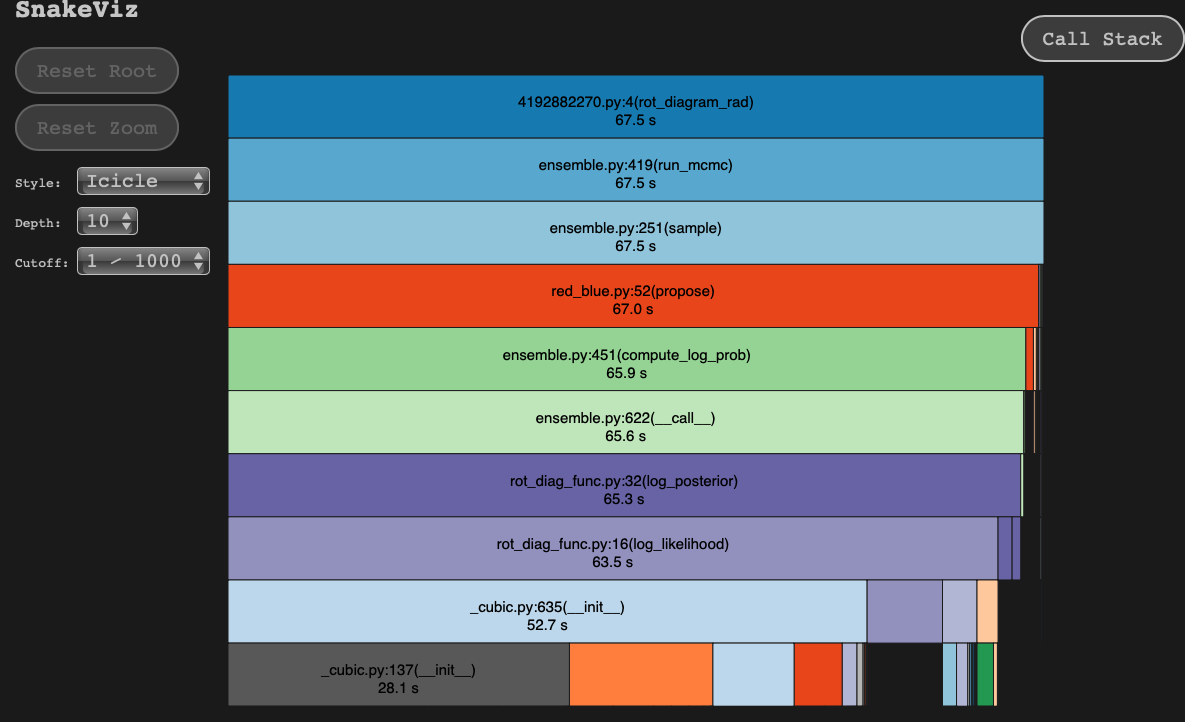

In [8]:
display.Image("bad.png")

I discovered I was being very silly in setting the interpolator for every iteration inside the for loop, while I could just set it up outside the for loop and pass "interpolate" to the likelihood. See the modified code below. Also put the assertion outside loop.

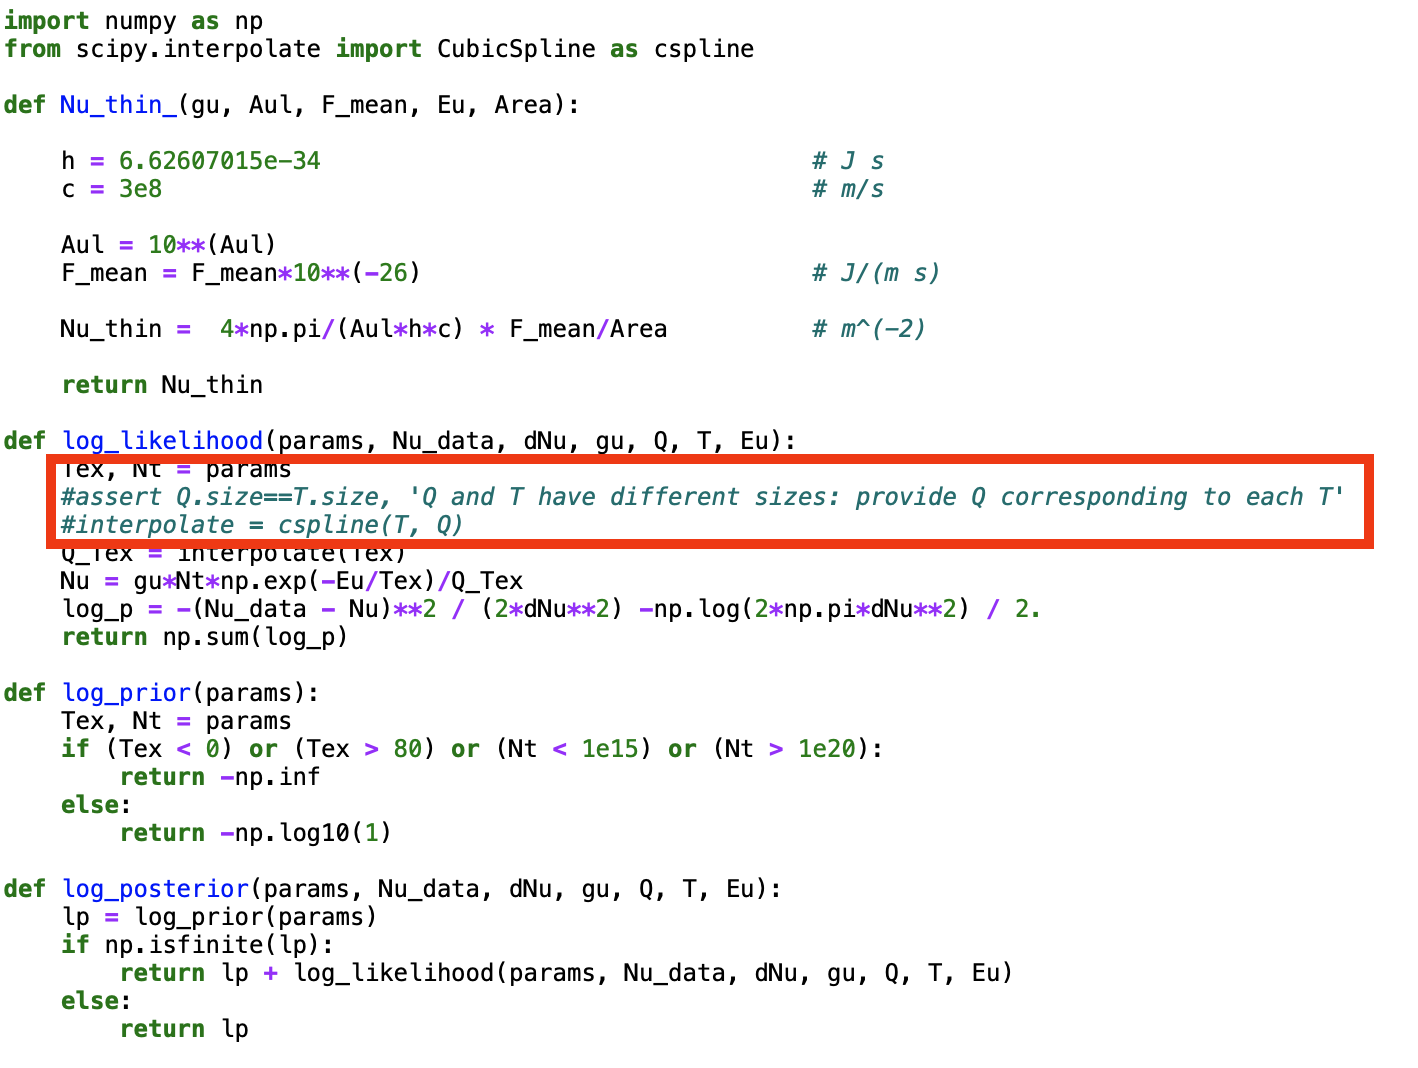

In [10]:
display.Image("bad_code.png")

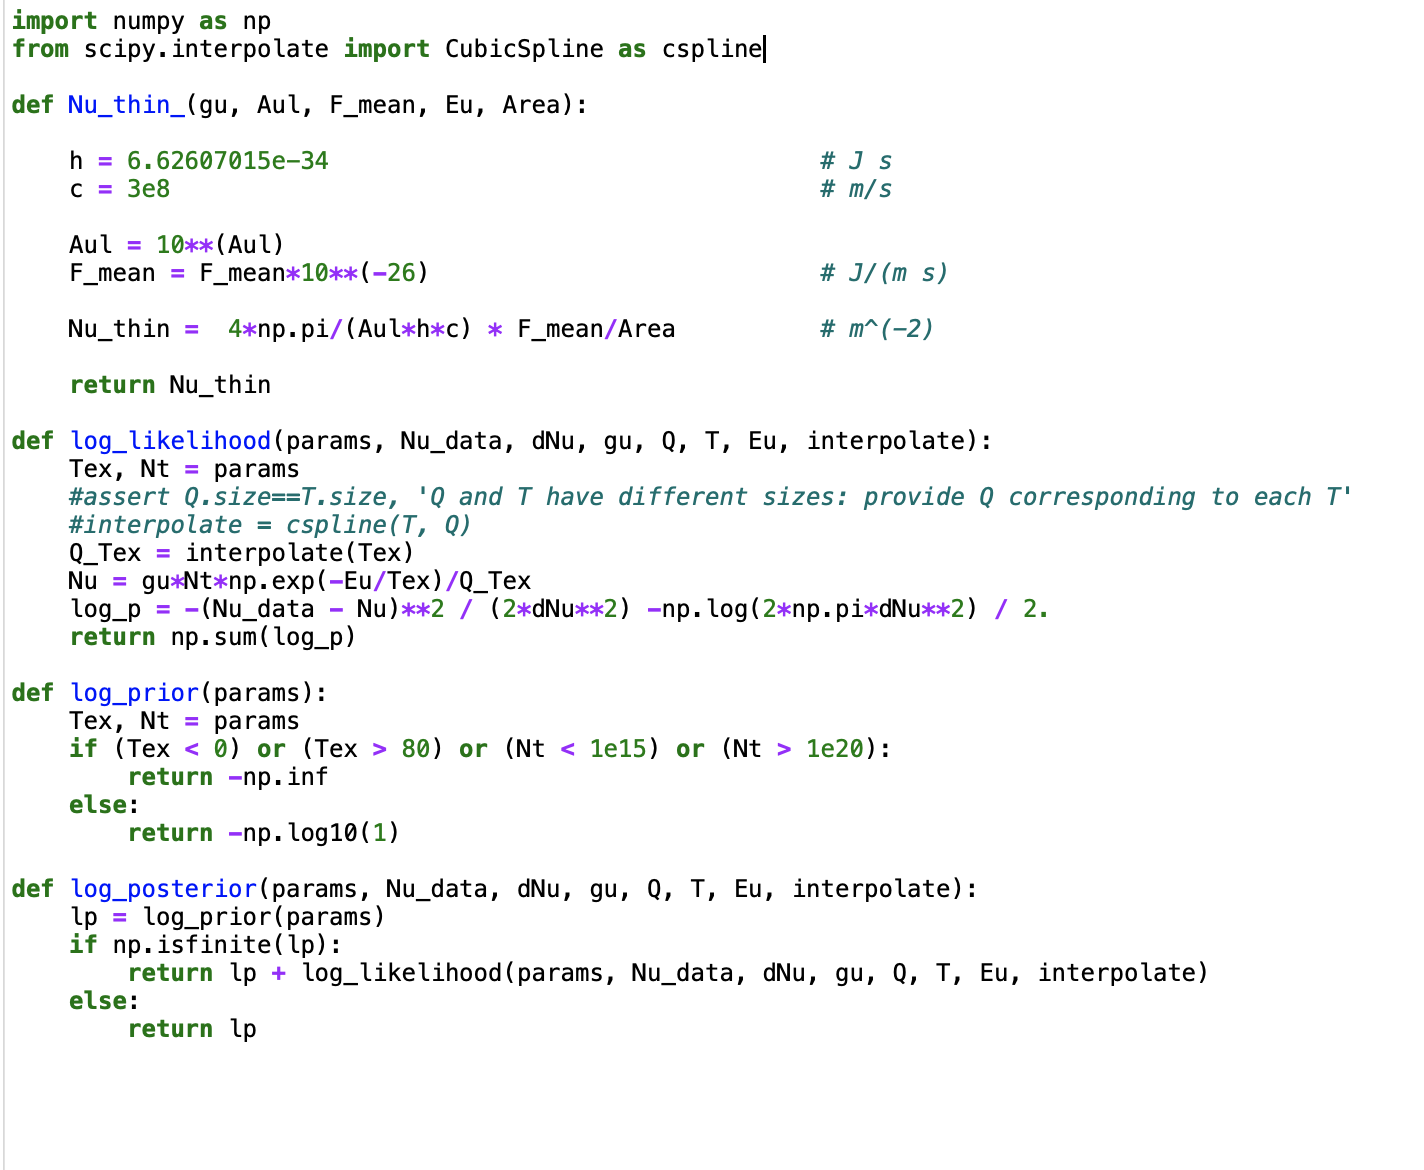

In [12]:
display.Image("better_code.png")

In [5]:
# New function

from scipy.interpolate import CubicSpline as cspline
import emcee
import corner

def rot_diagram_rad(rvals, Nu, dNu, gu, Eu, T = np.array([9.375, 18.75, 37.50, 75.00, 150., 225., 300.]), nwalkers=128, ndim=2, nburnin=500, nsteps=200):
    
    assert Q.size==T.size, 'Q and T have different sizes: provide Q corresponding to each T'
    interpolate = cspline(T, Q)
    
    nwalkers = nwalkers
    ndim = ndim
    nburnin = nburnin #not checking convergence, this is just to test multiprocessing
    nsteps = nsteps

    posterior = np.zeros((rvals.size, ndim, nwalkers*nsteps))
    for i in range(len(rvals)):
        #fit for N and Tex for each radius
        Nu_data = np.array([Nu[0,i], Nu[1,i]]) #data from radial profile of integrated intensity
        dNu_data = np.array([dNu[0,i], dNu[1,i]])   #statistical uncertainty
        pos = np.random.uniform(low=[25,1e16], high=[35,1e17], size=(nwalkers, ndim))

        sampler = emcee.EnsembleSampler(nwalkers, ndim, tools.log_posterior, args=(Nu_data, dNu_data, gu, Q, T, Eu, interpolate))
        state = sampler.run_mcmc(pos, nburnin)
        sampler.reset();
        sampler.run_mcmc(state, nsteps, progress=True);

        posterior[i] = sampler.flatchain[:,0]
    return posterior

In [6]:
import cProfile 
with cProfile.Profile() as pr:
    rot_diagram_rad(rvals=rvals, Nu=Nu, dNu=dNu, gu=gu, Eu=Eu) 

pr.dump_stats('example_better.prof')

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 207.34it/s]


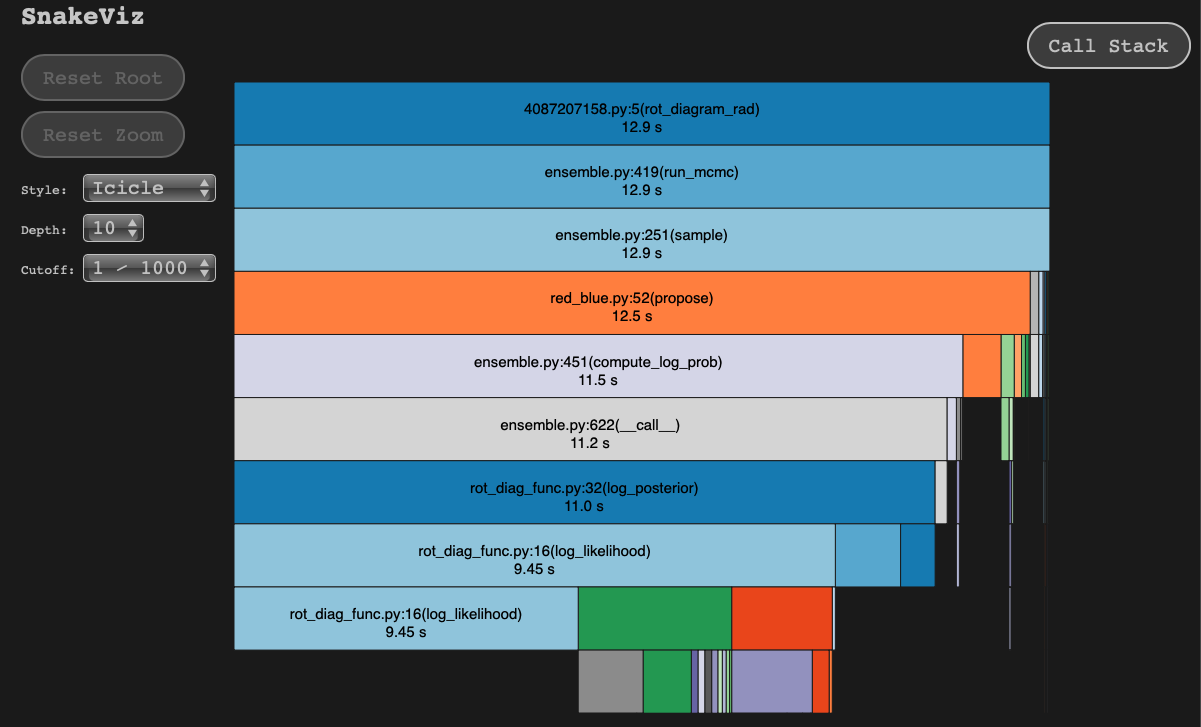

In [11]:
display.Image("better.png")